In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df=pd.read_excel("/content/karathkodu_rainfall_flow_ep.xlsx")
Area=775*10**6
df["flow(mm)"]=(df["flow(cumecs)"]/(Area))*86400*1000
P=df["rainfall(mm)"].to_list()
Ep=df["Ep(mm)"].to_list()
df

,Dates,flow(cumecs),rainfall(mm),Ep(mm),flow(mm)
0,1987-01-01,4.800,0.0,3.656071,0.535123
1,1987-01-02,4.700,0.0,3.385515,0.523974
2,1987-01-03,3.900,0.0,3.485735,0.434787
3,1987-01-04,4.300,0.0,3.374357,0.479381
4,1987-01-05,3.300,0.0,3.503790,0.367897
...,...,...,...,...,...
10953,2016-12-27,0.000,0.0,3.550263,0.000000
10954,2016-12-28,104.458,0.0,3.503551,11.645382
10955,2016-12-29,177.805,0.0,3.565737,19.822390
10956,2016-12-30,123.376,0.0,3.452510,13.754434


In [ ]:
def unsaturated_zone_plateau(P,Ep,Su_max,Su_o,alpha,Ks,a):
  E=[]
  Qu=[]
  Su=[]
  rec=[]
  P=[0]+P
  E=[0]+E
  Ep=[0]+Ep
  Qu=[0]+Qu
  rec=[0]+rec
  Su=[Su_o]+Su


  for t in range(1,len(P),1):
    E.insert(t,(Ep[t]*Su[t-1])/Su_max)
    fmax=min(P[t],Ks+(a/Su[t-1]))
    Q_=P[t]-fmax
    Qu.insert(t,Q_)
    rec_=Ks*((Su[t-1]/Su_max)**alpha)
    rec.insert(t,rec_)
    Su.insert(t,Su[t-1] + P[t] -E[t] - rec[t]-Qu[t])


  df=pd.DataFrame()
  df["P"]=P
  df["Ep"]=Ep
  df["E"]=E
  df["Qu"]=Qu
  df["rec"]=rec
  df["Su"]=Su

  return(Qu[1:],rec[1:])

# returns surface flow and recharge

In [ ]:
def groundwater_bucket_plateau(rec,kg,Sg_max,Sg_o):
  Sg=[]
  bf=[]
  rec=[0]+rec
  Sg=[Sg_o]+Sg
  bf=[0]+bf

  for t in range(1,len(rec),1):
    bf.insert(t,kg*Sg[t-1])
    Sg.insert(t,Sg[t-1] + rec[t] - bf[t])

  df=pd.DataFrame()
  df["rec"]=rec
  df["bf"]=bf
  df["Sg"]=Sg
  return(bf[1:])

In [ ]:
# takes flow and max flow, returns lagged flow

def lag_plateau(flow,max_lag):

  def weight_calculator(lag):
    W=[]
    for i in range(lag):
      W.insert(i,(2*i+1)/(lag**2))
    return(W)

  X = weight_calculator(max_lag)
  A = flow
  New=[]

  for i in range(0,len(A)):
    newvar = 0
    if i<=len(X)-1:
        for j in range(0,i+1):
            newvar = newvar + (A[j]*X[i-j])
    else:
        for j in range(0,len(X)) :
            newvar = newvar + (A[j+i-len(X)+1]*X[len(X)-j-1])
    New.append(newvar)

  return(New)

In [ ]:
def trial(P,Ep,Su_max,Su_o,alpha,Ks,a,kg,Sg_max,Sg_o,max_lag) :

  Qu_plateau,rec_plateau=unsaturated_zone_plateau(P,Ep,Su_max,Su_o,alpha,Ks,a)
  bf_plateau= groundwater_bucket_plateau(rec_plateau,kg,Sg_max,Sg_o)
  Qu_plateau_lag=lag_plateau(Qu_plateau,max_lag)
  Q_plateau = [sum(value) for value in zip(Qu_plateau_lag,bf_plateau)]

  df["Q_plateau"]=Q_plateau

  df_annual=df.groupby(df.Dates.dt.year)['rainfall(mm)','flow(mm)','Ep(mm)',"Q_plateau"].sum().reset_index()

  def nse(targets,predictions):
    return 1-(np.sum((targets-predictions)**2)/np.sum((targets-np.mean(predictions))**2))


  nse_value=round(nse(df_annual["flow(mm)"],df_annual["Q_plateau"]),4)

  plt.figure(figsize=(8,6))
  plt.plot(df_annual["Dates"],df_annual["Q_plateau"],label='simulated')
  plt.plot(df_annual["Dates"],df_annual["flow(mm)"],label='original')

  plt.xlabel("year")
  plt.ylabel("mm/year")
  plt.legend()
  print(nse_value)
  plt.show()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # Remove the CWD from sys.path while we load stuff.


0.3086


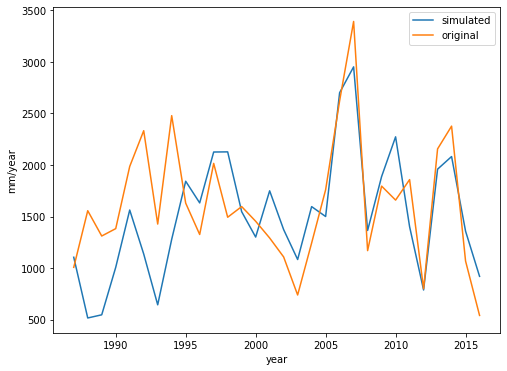

In [ ]:
trial(P=P,Ep=Ep,Su_max=600,Su_o=550,alpha=12,Ks=45,a=220,kg=0.1,Sg_max=750,Sg_o=700,max_lag=20)